In [1]:
import glob
import os
import json
import pickle
import yaml
import math

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import pyarrow.parquet as pq
from sklearn.metrics import auc, roc_curve
from scipy.special import softmax

import hist as hist2
import matplotlib.pyplot as plt
import mplhep as hep

plt.style.use(hep.style.CMS)

import sys
sys.path
sys.path.append("../python/")

import utils

plt.rcParams.update({"font.size": 20})

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# get lumi
with open("../fileset/luminosity.json") as f:
    luminosity = json.load(f)
    
luminosity

{'ele': {'Run2': 137640.0,
  '2016APV': 19492.72,
  '2016': 16809.96,
  '2017': 41476.02,
  '2018': 59816.23},
 'mu': {'Run2': 137640.0,
  '2016APV': 19436.16,
  '2016': 16810.81,
  '2017': 41475.26,
  '2018': 59781.96},
 'lep': {'Run2': 137640.0,
  '2016APV': 19436.16,
  '2016': 16810.81,
  '2017': 41475.26,
  '2018': 59781.96}}

In [4]:
full_lumi = luminosity["lep"]["Run2"]
full_lumi = full_lumi/1000
full_lumi

137.64

In [68]:
# get lumi
import pickle as pkl
with open("../combine/templates/v5/hists_templates_Run2.pkl", "rb") as f:
    h = pkl.load(f)

In [69]:
h

{'pass': Hist(
   StrCategory(['DYJets', 'Data', 'VBF', 'VH', 'WJetsLNu', 'TTbar', 'SingleTop', 'ggF', 'Diboson', 'QCD', 'ttH', 'WZQQ'], growth=True, name='Sample'),
   StrCategory(['nominal', 'weight_pileupUp', 'weight_pileupDown', 'weight_isolationUp', 'weight_isolationDown', 'weight_idUp', 'weight_idDown', 'weight_reco_eleUp', 'weight_reco_eleDown', 'weight_L1PrefiringUp', 'weight_L1PrefiringDown', 'weight_trigger_eleUp', 'weight_trigger_eleDown', 'weight_trigger_iso_muUp', 'weight_trigger_iso_muDown', 'weight_trigger_noniso_muUp', 'weight_trigger_noniso_muDown', 'weight_aS_weightUp', 'weight_aS_weightDown', 'weight_UEPS_FSRUp', 'weight_UEPS_FSRDown', 'weight_UEPS_ISRUp', 'weight_UEPS_ISRDown', 'weight_PDF_weightUp', 'weight_PDF_weightDown', 'weight_PDFaS_weightUp', 'weight_PDFaS_weightDown', 'weight_scalevar_3ptUp', 'weight_scalevar_3ptDown', 'weight_scalevar_7ptUp', 'weight_scalevar_7ptDown', 'weight_d1kappa_EWUp', 'weight_d1kappa_EWDown', 'weight_d1K_NLOUp', 'weight_d1K_NLODown',

In [71]:
h["pass"]

Hist(
  StrCategory(['DYJets', 'Data', 'VBF', 'VH', 'WJetsLNu', 'TTbar', 'SingleTop', 'ggF', 'Diboson', 'QCD', 'ttH', 'WZQQ'], growth=True, name='Sample'),
  StrCategory(['nominal', 'weight_pileupUp', 'weight_pileupDown', 'weight_isolationUp', 'weight_isolationDown', 'weight_idUp', 'weight_idDown', 'weight_reco_eleUp', 'weight_reco_eleDown', 'weight_L1PrefiringUp', 'weight_L1PrefiringDown', 'weight_trigger_eleUp', 'weight_trigger_eleDown', 'weight_trigger_iso_muUp', 'weight_trigger_iso_muDown', 'weight_trigger_noniso_muUp', 'weight_trigger_noniso_muDown', 'weight_aS_weightUp', 'weight_aS_weightDown', 'weight_UEPS_FSRUp', 'weight_UEPS_FSRDown', 'weight_UEPS_ISRUp', 'weight_UEPS_ISRDown', 'weight_PDF_weightUp', 'weight_PDF_weightDown', 'weight_PDFaS_weightUp', 'weight_PDFaS_weightDown', 'weight_scalevar_3ptUp', 'weight_scalevar_3ptDown', 'weight_scalevar_7ptUp', 'weight_scalevar_7ptDown', 'weight_d1kappa_EWUp', 'weight_d1kappa_EWDown', 'weight_d1K_NLOUp', 'weight_d1K_NLODown', 'weight_d2

In [50]:
import uproot
# f = uproot.open("FitShapesv3withopposite.root")
f = uproot.open("fitDiagnosticsBlinded.root")
# f = uproot.open("fitDiagnosticsBlindedpassfail.root")

In [51]:
samples = [
    "data",
    "total_background",
    "total_signal",
    "CMS_HWW_boosted_qcd_datadriven",
    "wjets",    
    "ttbar",
]

/Users/fmokhtar/miniconda3/envs/coffea-env/lib/python3.9/site-packages/mplhep/error_estimation.py:49: RuntimeWarning: divide by zero encountered in divide
  counts = sumw / scale
/Users/fmokhtar/miniconda3/envs/coffea-env/lib/python3.9/site-packages/mplhep/utils.py:197: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)


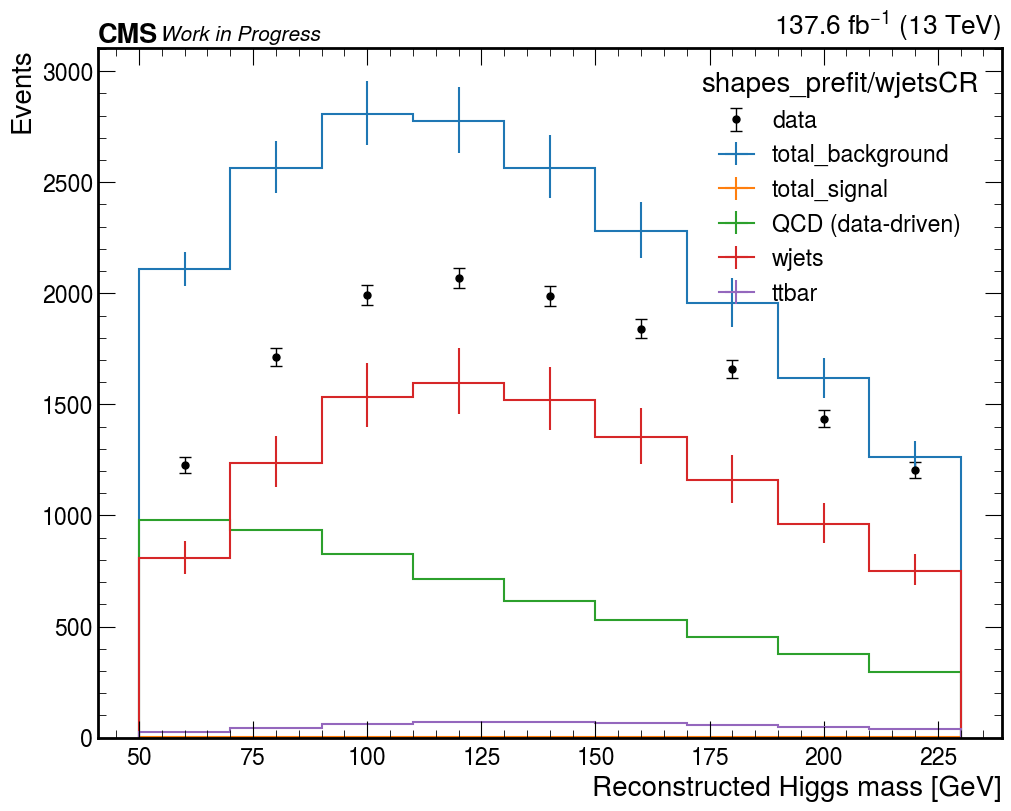

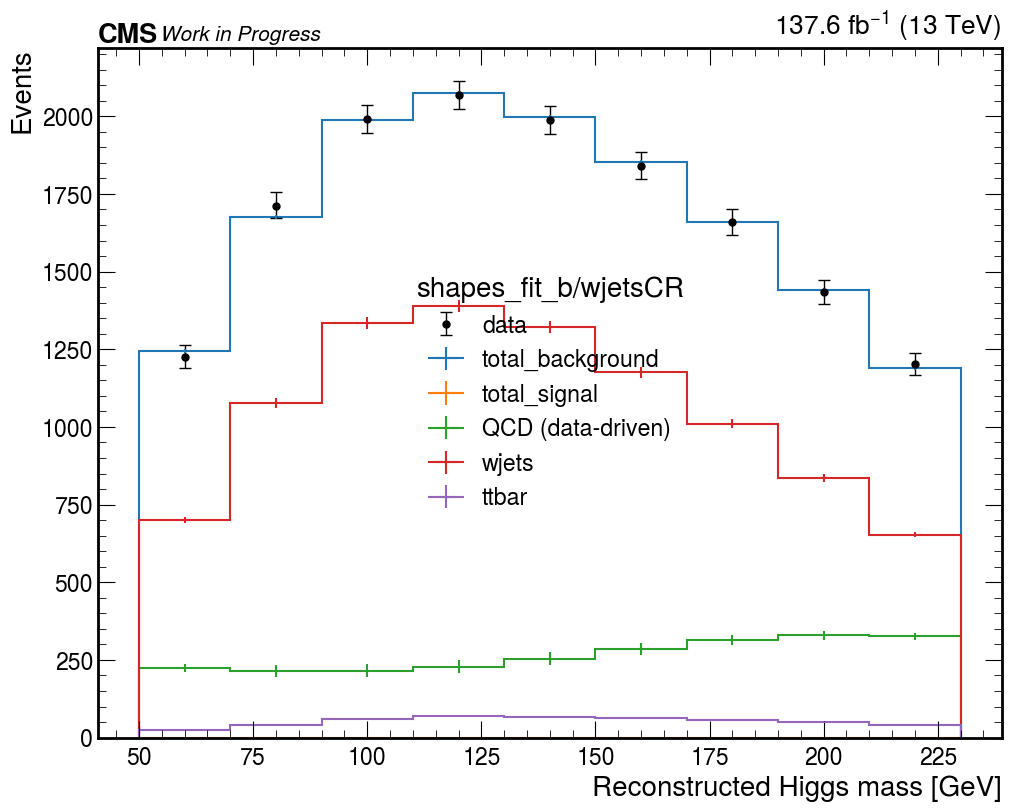

In [54]:
region = "wjetsCR"

for key in [f"shapes_prefit/{region}", f"shapes_fit_b/{region}"]:
    fig, ax = plt.subplots(figsize=(10,8), constrained_layout=True)

    for sample in samples:
        if "qcd" in sample:
            if region == "passBlinded2":
                sample += f"_pass"
            else:
                sample += f"_{region}"
            
        if sample == "data":
            
            hep.histplot(
                f[key]["data"].values()[1],
                bins=list(range(50, 240, 20)),
                ax=ax,
                label=sample,
                histtype="errorbar",
                color="k",
                capsize=4,           
            )   

        else:
            if "qcd" in sample:
                lab = "QCD (data-driven)"
            else:
                lab = sample

            hep.histplot(             
                f[key][sample],
                ax=ax,
                histtype="step",
                label=lab,
            )    

    ax.legend(title=key)
    ax.set_ylabel(f"Events")
    ax.set_xlabel(f"Reconstructed Higgs mass [GeV]")
    ax.set_ylim(0)    
    hep.cms.lumitext("%.1f " % full_lumi + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
    hep.cms.text("Work in Progress", ax=ax, fontsize=15)

In [17]:
samples = [
#     "data",
    "total_background",
    "total_signal",
#     "CMS_HWW_boosted_qcd_datadriven",
    "wjets",    
    "ttbar",
    "zjets",
    "singletop",
    "total_covar"
]

(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Work in Progress'))

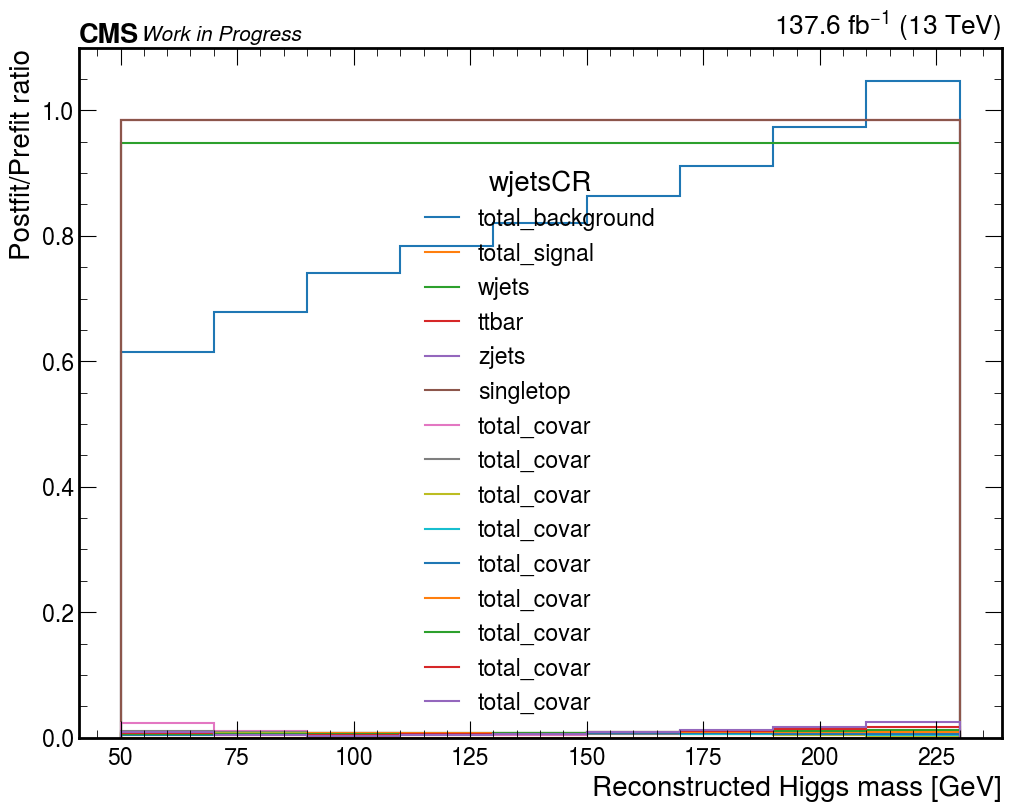

In [10]:
region = "wjetsCR"

if region=="pass":
    region += "Blinded"

fig, ax = plt.subplots(figsize=(10,8), constrained_layout=True)
for sample in samples:


    if sample == "data":
        num = f[f"shapes_fit_b/{region}"]["data"].values()[1]
        den = f[f"shapes_prefit/{region}"]["data"].values()[1]

        hep.histplot(
            num/den,
            bins=list(range(50, 240, 20)),
            ax=ax,
            label=sample,
            histtype="errorbar",
            color="k",
            capsize=4,           
        )   

    else:
        num = f[f"shapes_fit_b/{region}"][sample].values()
        den = f[f"shapes_prefit/{region}"][sample].values()

        hep.histplot(
            num/den,
            bins=list(range(50, 240, 20)),
            ax=ax,
            histtype="step",
            label=sample,
        )    

ax.legend(title=region)
ax.set_ylabel(f"Postfit/Prefit ratio")
ax.set_xlabel(f"Reconstructed Higgs mass [GeV]")
ax.set_ylim(0)    
hep.cms.lumitext("%.1f " % full_lumi + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)

In [428]:
f["shapes_prefit/passBlinded"]["wjets"].values()

array([1.4160691, 3.8754134, 0.       , 0.       , 0.       , 5.597086 ,
       5.7969   , 4.6152887, 3.6734428], dtype=float32)